In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split 
import math
from tensorflow.keras.utils import to_categorical
import os
import cv2


In [2]:
cat_path = "datasett-hundogkatt/training_set/training_set/cats/"
dog_path = "datasett-hundogkatt/training_set/training_set/dogs/"

In [3]:
cat_img = []
for i in os.listdir(cat_path):
    if i.endswith(".jpg"):
        temp_img = cv2.imread(os.path.join(cat_path, i), cv2.IMREAD_GRAYSCALE)
        temp_img = cv2.resize(temp_img, (128,128), interpolation= cv2.INTER_LINEAR )
        cat_img.append(temp_img)

In [4]:
cat_img = np.asarray(cat_img)
cat_img = np.expand_dims(cat_img,-1)

In [5]:
y_cat = np.zeros(cat_img.shape[0])

In [6]:
dog_img = []
for i in os.listdir(dog_path):
    if i.endswith(".jpg"):
        temp_img = cv2.imread(os.path.join(dog_path, i), cv2.IMREAD_GRAYSCALE)
        temp_img = cv2.resize(temp_img, (128,128), interpolation= cv2.INTER_LINEAR )
        dog_img.append(temp_img)

In [7]:
dog_img = np.asarray(dog_img)
dog_img = np.expand_dims(dog_img,-1)

In [8]:
y_dog = np.ones(dog_img.shape[0])

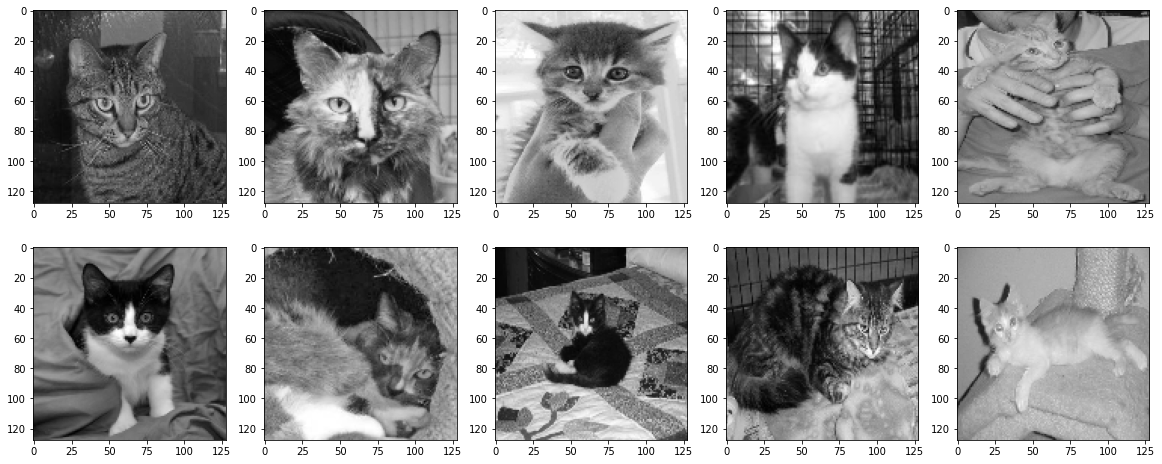

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(cat_img[i],cmap='gray', vmin=0, vmax=255)

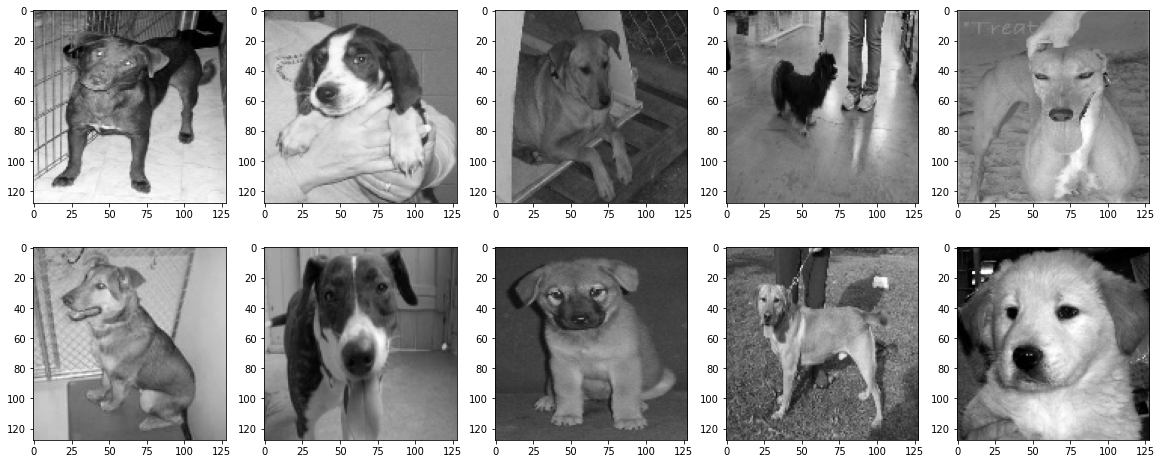

In [10]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(dog_img[i],cmap='gray', vmin=0, vmax=255)

In [11]:
X = np.vstack([cat_img,dog_img])

In [12]:
y = np.hstack([y_cat,y_dog])

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

In [14]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([3211, 3193], dtype=int64))

In [15]:
np.unique(y_val, return_counts=True)

(array([0., 1.]), array([789, 812], dtype=int64))

In [16]:
y_train = np.expand_dims(y_train ,-1)

In [17]:
X_train.shape

(6404, 128, 128, 1)

In [18]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    classes=1,
    classifier_activation="softmax",
    input_shape=(128, 128, 3)
)

In [19]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
pred = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs = base_model.input, outputs = pred)

In [21]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(curve='ROC')])

In [22]:
history = model.fit(x=X_train,y=y_train, epochs=15, batch_size=64, validation_data=(X_val,y_val), shuffle=True)

Epoch 1/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 559ms/step - auc: 0.5933 - binary_accuracy: 0.5576 - loss: 0.6829 - val_auc: 0.8910 - val_binary_accuracy: 0.8070 - val_loss: 0.5530
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - auc: 0.9185 - binary_accuracy: 0.8296 - loss: 0.5185 - val_auc: 0.9667 - val_binary_accuracy: 0.8976 - val_loss: 0.4299
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step - auc: 0.9716 - binary_accuracy: 0.9119 - loss: 0.4038 - val_auc: 0.9804 - val_binary_accuracy: 0.9219 - val_loss: 0.3460
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 475ms/step - auc: 0.9818 - binary_accuracy: 0.9277 - loss: 0.3306 - val_auc: 0.9852 - val_binary_accuracy: 0.9344 - val_loss: 0.2883
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step - auc: 0.9841 - binary_accuracy: 0.9330 - loss: 0.2800 - val_auc: 0.9878 - val_binary_accuracy: 0.9432 - val_loss: 0.2474
Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - auc: 0.9874 - binary_accuracy: 0.9423 - loss: 0.2395 - val

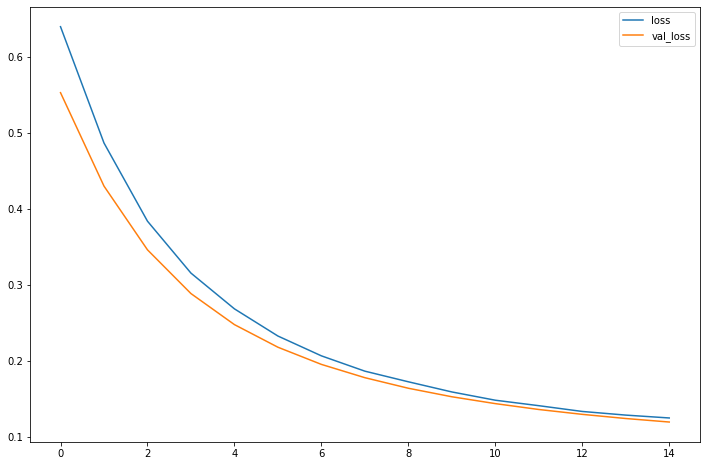

In [32]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

In [33]:
history.history.keys()

dict_keys(['auc', 'binary_accuracy', 'loss', 'val_auc', 'val_binary_accuracy', 'val_loss'])

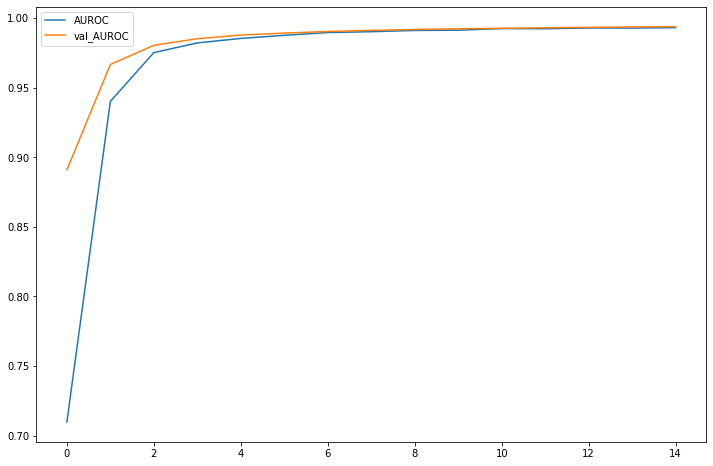

In [34]:
plt.figure(figsize=(12,8))
plt.plot(history.history["auc"], label="AUROC")
plt.plot(history.history["val_auc"], label="val_AUROC")
plt.legend()
plt.show()

In [26]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [27]:
from IPython.display import Image, display
import matplotlib as mpl
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=1.0):
    # Load the original image


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["Reds"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)


    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)


In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 128, 128, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 128, 128, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 64, 64, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 64, 64, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 64, 64, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 64, 64, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 64, 64, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 64, 64, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 32, 32, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 32, 32, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 32, 32, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 32, 32, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 32, 32, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2b_expand_conv (Conv2D)  │ (None, 32, 32, 128)       │          36,86

 Total params: 6,411,605 (24.46 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 328,196 (1.25 MB)

In [29]:
# GradCam - lokal forklaring - spesifikt for CNN modeller

In [30]:
img_indx = 6
heat_map = make_gradcam_heatmap(X_val[img_indx:img_indx+1], model, "stem_conv", pred_index=None)

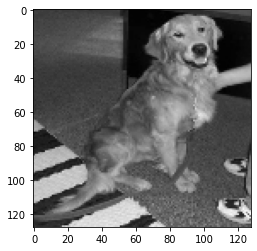

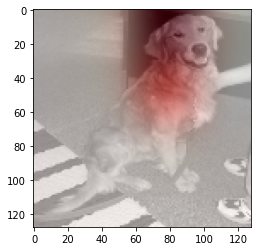

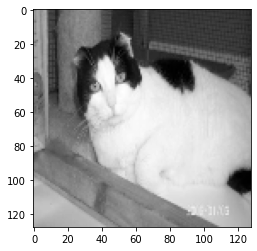

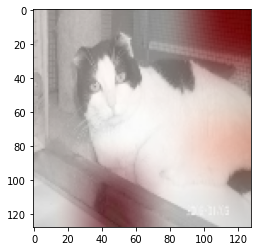

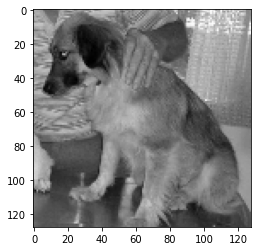

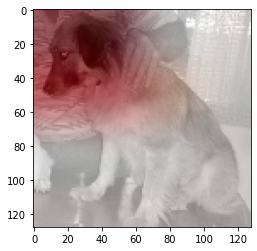

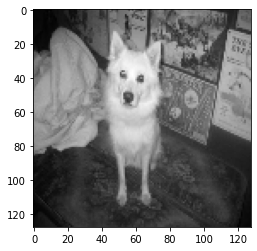

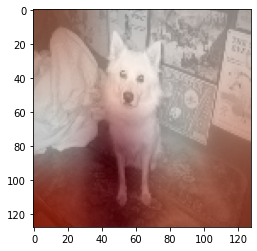

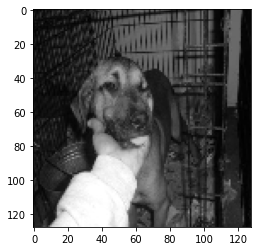

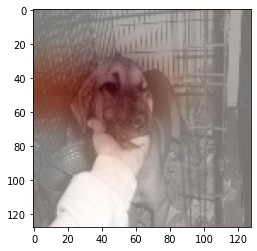

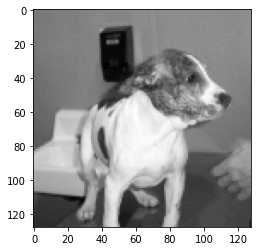

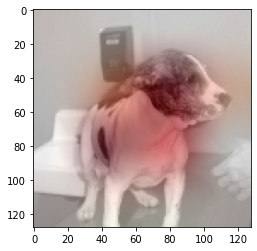

In [31]:
for img_indx in range(6):
    heat_map = make_gradcam_heatmap(X_val[img_indx:img_indx+1], model, "top_conv", pred_index=None)
    plt.figure()
    plt.imshow( tf.keras.utils.array_to_img(X_val[img_indx]),cmap='gray')
    plt.show()
    save_and_display_gradcam(X_val[img_indx],heat_map)

In [35]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [80]:
import tensorflow as tf
import numpy as np
from typing import Optional, Union

def fgsm_attack(
    model: tf.keras.Model,
    x: Union[tf.Tensor, np.ndarray],
    epsilon: float = 0.01,
    y: Optional[Union[tf.Tensor, np.ndarray]] = None,
    targeted: bool = False,
    clip_min: float = 0.0,
    clip_max: float = 1.0,
    loss_fn: Optional[tf.keras.losses.Loss] = None,
) -> tf.Tensor:
    """
    Create FGSM adversarial examples for inputs x.

    Args:
        model: tf.keras.Model - model mapping input->logits or predictions.
        x: input batch, shape (batch_size, ...). Will be cast to float32.
        epsilon: attack strength (L_inf).
        y: optional labels. If None, uses argmax(model(x)) as labels (sparse).
           y can be:
             - None
             - sparse integer labels shape (batch,)
             - one-hot labels shape (batch, num_classes)
        targeted: if True, generate a targeted attack (move inputs toward y).
                  if False, untargeted (move away from y).
        clip_min, clip_max: clip adversarial examples to this range.
        loss_fn: optional tf.keras.losses.Loss instance. If None, will pick:
             - SparseCategoricalCrossentropy(from_logits=True) for sparse labels
             - CategoricalCrossentropy(from_logits=True) for one-hot labels
             - BinaryCrossentropy(from_logits=True) if model has single logit output

    Returns:
        adv_x : tf.Tensor, same shape as x, adversarial examples clipped to [clip_min, clip_max].
    """
    x_tensor = tf.cast(x, tf.float32)
    x_tensor = tf.identity(x_tensor)  # avoid accidental in-place

    # Run a forward pass to infer shape/classes if needed
    logits = model(x_tensor)
    # If model returns probabilities, convert to logits for stable loss usage by setting from_logits=False later
    # But we'll assume model returns logits or a probability vector. We'll infer num_classes:
    if isinstance(logits, (list, tuple)):
        raise ValueError("Model returned multiple tensors; pass a model that returns logits/probs as single tensor.")
    logits = tf.convert_to_tensor(logits)

    batch_size = tf.shape(x_tensor)[0]
    num_classes = tf.shape(logits)[-1] if logits.shape.rank >= 2 else 1

    # Prepare labels
    if y is None:
        # avoid label leaking: use model argmax predictions as sparse labels
        if num_classes == 1:
            # binary single-logit case => model.predict_proba threshold 0.5 -> integer label
            preds = tf.sigmoid(logits)
            y_sparse = tf.cast(tf.greater(preds, 0.5), tf.int32)
            y_tensor = tf.reshape(y_sparse, [batch_size])
            is_one_hot = False
        else:
            preds = tf.argmax(logits, axis=-1)
            y_tensor = tf.cast(preds, tf.int32)
            is_one_hot = False
    else:
        y_tensor = tf.convert_to_tensor(y)
        # Determine whether y is one-hot
        if y_tensor.dtype.is_floating and y_tensor.shape.rank == logits.shape.rank and y_tensor.shape[-1] == logits.shape[-1]:
            is_one_hot = True
        elif y_tensor.shape.rank == 2 and y_tensor.shape[-1] == logits.shape[-1]:
            # integer but shaped like (batch, num_classes) -> treat as one-hot
            is_one_hot = True
            y_tensor = tf.cast(y_tensor, tf.float32)
        else:
            # treat as sparse labels
            is_one_hot = False
            y_tensor = tf.cast(tf.reshape(y_tensor, [batch_size]), tf.int32)

    # Choose or validate loss function
    if loss_fn is None:
        if num_classes == 1:
            loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        else:
            if is_one_hot:
                loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
            else:
                loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Gradient computation
    x_var = tf.Variable(x_tensor)

    with tf.GradientTape() as tape:
        tape.watch(x_var)
        preds = model(x_var)

        # compute loss according to label format
        if isinstance(loss_fn, tf.keras.losses.BinaryCrossentropy):
            # binary case: accept labels either shape (batch,) or (batch,1)
            if is_one_hot:
                # convert one-hot 2-class to single column
                if y_tensor.shape.rank == 2 and y_tensor.shape[-1] == 2:
                    # take second column as positive class probability target
                    y_for_loss = tf.reshape(y_tensor[..., 1], [batch_size, 1])
                else:
                    y_for_loss = tf.reshape(y_tensor, [batch_size, 1])
            else:
                y_for_loss = tf.cast(tf.reshape(y_tensor, [batch_size, 1]), tf.float32)
            loss = loss_fn(y_for_loss, preds)
        else:
            if is_one_hot:
                loss = loss_fn(y_tensor, preds)
            else:
                loss = loss_fn(y_tensor, preds)

        # For targeted attack, we want to minimize loss towards target => negate gradient direction:
        if targeted:
            loss = -loss

    # compute gradient of loss wrt input
    grad = tape.gradient(loss, x_var)
    if grad is None:
        raise RuntimeError("Gradient is None; check that the model's output depends on the input.")

    # FGSM perturbation (L_inf): sign(grad)
    signed_grad = tf.sign(grad)
    adv_x = x_tensor + epsilon * signed_grad

    # clip and return
    adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)
    return adv_x


In [126]:
epsilon = 10
adv = fgsm_attack(model, X_val[:1], epsilon=epsilon, y=y_val[:1], targeted=False, clip_min=0.0, clip_max=256)

In [127]:
model.predict(adv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([[0.7486899]], dtype=float32)

In [128]:
adv.shape

TensorShape([1, 128, 128, 1])

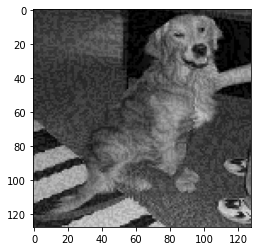

In [129]:
#Show the image
plt.figure()
plt.grid(False)

plt.imshow(adv[0],cmap='gray', vmin=0, vmax=255)
#plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
#plt.xlabel("Original Label: {}".format(y_val[0]))

plt.show()

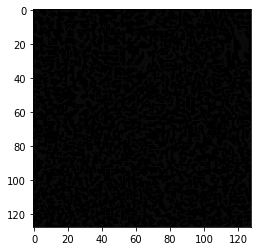

In [130]:
plt.imshow(adv[0]-X_val[0],cmap='gray', vmin=0, vmax=255)

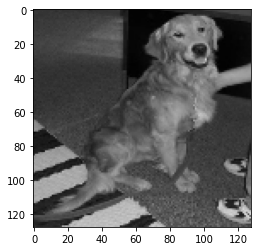

In [131]:
plt.imshow(X_val[0],cmap='gray', vmin=0, vmax=255)